In [1]:
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.ticker import MaxNLocator
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage

import scheduler_mda as sch_mda

In [2]:
case_path = os.path.join(os.path.dirname(os.getcwd()), "data", "gantt.csv")
session_path = os.path.join(os.path.dirname(os.getcwd()), "data", "sessions_mda.csv")
# case_path = os.path.join(os.path.dirname(os.getcwd()), "data", "gantt_main.csv")
# session_path = os.path.join(os.path.dirname(os.getcwd()), "data", "sessions_mda_main.csv")
options = {"seconds": 500}

In [3]:
df = pd.read_csv(case_path)
df=df.assign(CaseID=range(len(df)))
df['Scheduled Setup Start']=pd.to_datetime(df['Scheduled Setup Start'])
df['Scheduled Cleanup Complete']=pd.to_datetime(df['Scheduled Cleanup Complete'])
df['Scheduled Room Duration']=(df['Scheduled Cleanup Complete']-df['Scheduled Setup Start']).astype('timedelta64[m]')
df["Case Expected Date"].fillna(method='ffill', inplace = True)
df['Room']=df.apply(lambda row: int(re.search(r'\d+', row['Room']).group()), axis = 1)
df = df.loc[df['Room']<41]
df = df.dropna()
df['Day']=df.groupby('Date').ngroup()
df['Room']=df['Room']+df['Day']*40
df['SurgeonID'] = df.groupby('Primary Surgeon Name').ngroup()

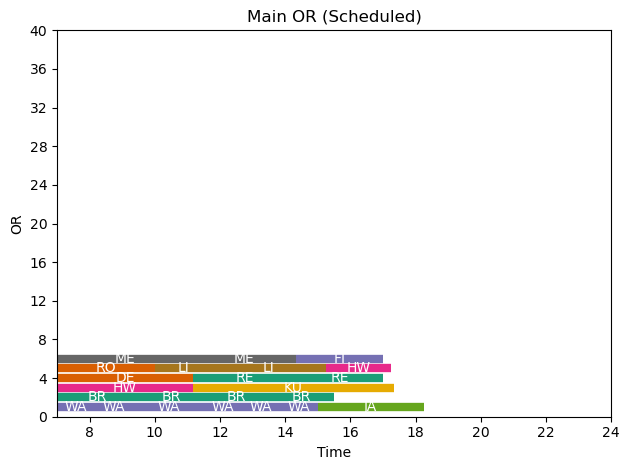

In [4]:
sessions = sorted(list(df['Room'].unique()))

# bar_style = {'alpha': 1.0, 'lw': 1, 'solid_capstyle': 'butt'} # 200
bar_style = {'alpha': 1.0, 'lw': 6, 'solid_capstyle': 'butt'}
text_style = {'color': 'white', 'ha': 'center', 'va': 'center'}
colors = cm.Dark2.colors

fig, ax = plt.subplots(1, 1)

for s_ix, s in df.iterrows():
    xs = s['Scheduled Setup Start'].hour + s['Scheduled Setup Start'].minute/60
    xf = s['Scheduled Cleanup Complete'].hour + s['Scheduled Cleanup Complete'].minute/60
    ax.plot([xs, xf], [s['Room']] * 2, c=colors[s['SurgeonID']%len(colors)], **bar_style)
    ax.text((xs + xf) / 2, s['Room'], s['Primary Surgeon Name'][:2], **text_style)

ax.set_title('Main OR (Scheduled)')
# ax.set_title('Mays OR (Actual)')
ax.set_xlabel('Time')

ax.set_ylabel('OR')
# ax.grid(True)
ax.set_xlim([7, 24])
ax.set_ylim([0, 40])

ax.yaxis.set_major_locator(MaxNLocator(integer=True))

fig.tight_layout()
plt.show()

In [3]:
scheduler = sch_mda.TheatreScheduler(case_file_path=case_path, session_file_path=session_path)

Welcome to the CBC MILP Solver 
Version: 2.10.8 
Build Date: May  5 2022 

command line - C:\Program Files\Cbc-releases.2.10.8-w64-msvc16-md\bin\cbc.exe -seconds 500 -printingOptions all -import C:\Users\lliu10\AppData\Local\Temp\tmp8643kxly.pyomo.lp -mipstart C:\Users\lliu10\AppData\Local\Temp\tmpd_oj1l2o.cbc.soln -stat=1 -solve -solu C:\Users\lliu10\AppData\Local\Temp\tmp8643kxly.pyomo.soln (default strategy 1)
seconds was changed from 1e+100 to 500
Option for printingOptions changed from normal to all
 CoinLpIO::readLp(): Maximization problem reformulated as minimization
Coin0009I Switching back to maximization to get correct duals etc
opening mipstart file .\C:\Users\lliu10\AppData\Local\Temp\tmpd_oj1l2o.cbc.soln.
Presolve 4835 (-2413) rows, 2544 (-2275) columns and 23370 (-4819) elements
Statistics for presolved model
Original problem has 4674 integers (4674 of which binary)
Presolved problem has 2406 integers (2406 of which binary)
==== 2406 zero objective 2 different
2406 variab

Cbc0038I Full problem 4835 rows 2544 columns, reduced to 4634 rows 1960 columns - too large
Cbc0038I Mini branch and bound did not improve solution (3.35 seconds)
Cbc0038I After 3.35 seconds - Feasibility pump exiting with objective of -16 - took 2.40 seconds
Cbc0012I Integer solution of -16 found by feasibility pump after 0 iterations and 0 nodes (3.36 seconds)
Cbc0038I Full problem 4835 rows 2544 columns, reduced to 3031 rows 638 columns - 184 fixed gives 1945, 386 - ok now
Cbc0038I Full problem 4835 rows 2544 columns, reduced to 1945 rows 386 columns
Cbc0031I 28 added rows had average density of 18.785714
Cbc0013I At root node, 28 cuts changed objective from -23 to -23 in 8 passes
Cbc0014I Cut generator 0 (Probing) - 0 row cuts average 0.0 elements, 0 column cuts (0 active)  in 0.059 seconds - new frequency is -100
Cbc0014I Cut generator 1 (Gomory) - 38 row cuts average 28.8 elements, 0 column cuts (0 active)  in 0.025 seconds - new frequency is 1
Cbc0014I Cut generator 2 (Knapsack)

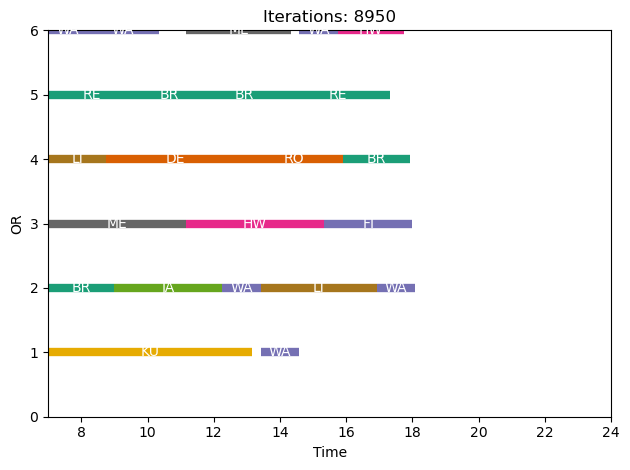

In [4]:
cbc_path = "C:\\Program Files\\Cbc-releases.2.10.8-w64-msvc16-md\\bin\\cbc.exe"
scheduler.solve(solver_name="cbc", solver_path=cbc_path, options=options)

In [62]:
times=[1.9, 10, 20, 34.87, 35.02, 40]
cnt=0
for x in times:
# for x in range(1,130,10):
    options = {"seconds": x}
    scheduler.solve(solver_name="cbc", solver_path=cbc_path, options=options)
    plt.savefig('test'+str(cnt)+'.png')
    cnt+=1

In [42]:
import os
import moviepy.video.io.ImageSequenceClip
image_folder='C:/Users/lliu10/OneDrive - Inside MD Anderson/Documents/GitHub/theatre-scheduling/modelling'
fps=1

image_files = [os.path.join(image_folder,img)
               for img in os.listdir(image_folder)
               if img.endswith(".png")]
clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(image_files, fps=fps)
clip.write_videofile('my_video.mp4')

Moviepy - Building video my_video.mp4.
Moviepy - Writing video my_video.mp4



Moviepy - Done !
Moviepy - video ready my_video.mp4
